In [1]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
import copy
import psycopg2
from pandas.io import sql
from functools import reduce
import scipy
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from scipy.spatial import distance
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
%pylab inline

/home/saadn22/.local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


In [2]:
# exclusions = pd.read_csv('UPDATED.csv')

In [3]:
# print(exclusions)

In [4]:
# excluded = pd.read_csv('UPDATED.csv')

In [5]:
# print(excluded.columns)

In [6]:
# q1 = " SELECT * from partd_base_no_year ; "
# q2 = " SELECT * from partd_outlier_no_year ; "
# q3 = " SELECT * from drug_weights_no_year ; "

In [7]:
# con = psycopg2.connect(host="localhost", user="postgres", password="Saad123", database="Medicare")

In [8]:
# df1 = pd.read_sql_query(q1,con)
# df2 = pd.read_sql_query(q2,con)
# df3 = pd.read_sql_query(q3,con)

In [9]:
# dfs = [df1,df2,df3]
# df = reduce(lambda left,right: pd.merge(left,right,on='npi'), dfs)

In [10]:
# df.columns

In [11]:
# excluded["year"] = excluded.EXCLDATE.apply(lambda x: int(str(x)[:4]))
# fraud_npi = excluded[(excluded.NPI != 0) & (excluded.year > 2015)].NPI.values
# print("Number of fraudulent NPI's: " + str(len(fraud_npi)))
# print((fraud_npi))

In [12]:
# # df["is_fraud"] = 0

# # df.loc[df.index.isin(fraud_npi),"is_fraud"] = 1
# # df.head()
# # print(df.index)
# df["is_fraud"] = 0
# for i in df.index:
#     if df['npi'][i] in fraud_npi:
#         df['is_fraud'][i] = 1
# # df.loc[df.index.isin(fraud_npi),"is_fraud"] = 1
# df.head()
# print(df.index)

In [2]:
categorical_features = [u'speciality']
numerical_features = []
numerical_features = ['nb_diff_prescriptions','sum_prescr','sum_days','sum_cost'
                      ,'var_prescr','var_days','var_cost'
                      ,'max_prescr','max_days','max_cost']
# base features
numerical_features = numerical_features + []
# outliers features
numerical_features = numerical_features +['nb_perc_presc', 'nb_perc_days', 'nb_perc_cost', 'perc_unicost']
# drug scores
numerical_features = numerical_features + ['weighted_score', 'score']
# outlier score
numerical_features = numerical_features + ['mahalanobis']

target = ['is_fraud']
allvars = categorical_features + numerical_features + target

In [3]:
# temp = df.drop('speciality',axis=1)
# covmx = temp.cov()
# VI = scipy.linalg.inv(covmx)

In [15]:
# temp = temp.values
# np.nan_to_num(temp)

In [4]:
# mean = np.nanmean(temp,axis=0)

In [17]:
# df['mahalanobis'] = 0
# for i in df.index:
#     delta = temp[i] - mean
#     mahalanobis_distance = np.sqrt(np.dot(np.dot(np.transpose(delta),VI),delta))
#     df['mahalanobis'][i] = mahalanobis_distance

In [18]:
# #Pickle dump of the final dataframe
# pickle_out = open('data_frame.pickle','wb')
# pickle.dump(df,pickle_out)
# pickle_out.close()

In [3]:
pickle_in = open('data_frame.pickle','rb')
df = pickle.load(pickle_in)

In [4]:
# filename = "clustering_file.csv"
# file = open(filename, 'wb')
# pickle.dump(df, file)
print(df.columns.size)

20


In [5]:
y = df["is_fraud"].values
X = df[allvars].drop('is_fraud',axis=1)

unique, counts = numpy.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

{0: 807263, 1: 710}


In [6]:
X_train, X_valid, y_train, y_valid = cross_validation.train_test_split(X, y, test_size=0.1, random_state=0)
print (X_train.shape, X_valid.shape)

(727175, 18) (80798, 18)


In [7]:
# filling missing values 
X_train[numerical_features] = X_train[numerical_features].fillna(0) # is mean better ? 
X_valid[numerical_features] = X_valid[numerical_features].fillna(0) # is mean better ? 
X_train[categorical_features] = X_train[categorical_features].fillna('unknown') 
X_valid[categorical_features] = X_valid[categorical_features].fillna('unknown')

In [8]:
# rescaling 
scaler= StandardScaler() 
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features].values)
X_valid[numerical_features] = scaler.transform(X_valid[numerical_features].values)

In [9]:
#Giving speciality a unique number
s = X_train[categorical_features].values
valid = X_valid[categorical_features].values
l1, l2 = pd.factorize(s.reshape((s.shape[0])))
l1
temp = X_train[:]
test = X_valid[:]

valid_nums, _ = pd.factorize(valid.reshape((valid.shape[0])))

In [10]:
temp[categorical_features] = l1
test[categorical_features] = valid_nums

In [11]:
X_train = temp
X_valid = test

In [13]:
# dummify categorical features, Getting a sparse matrix

# vectorizer = DictVectorizer()
# tmp = [dict(enumerate(sample)) for sample in X_train[categorical_features].values]
# tmp2 = [dict(enumerate(sample)) for sample in X_valid[categorical_features].values]
# X_train = scipy.sparse.hstack((X_train[numerical_features].values, vectorizer.fit_transform(tmp)))
# X_valid = scipy.sparse.hstack((X_valid[numerical_features].values, vectorizer.transform(tmp2)))

In [12]:
#Pickle dump of the final dataframe
pickle_out = open('data_frame_testing.pickle','wb')
pickle.dump(X_valid,pickle_out)
pickle_out.close()

In [13]:
# declare classifier 
clf1 = LogisticRegression() # pimp me 

In [14]:
# train model 1
clf1.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

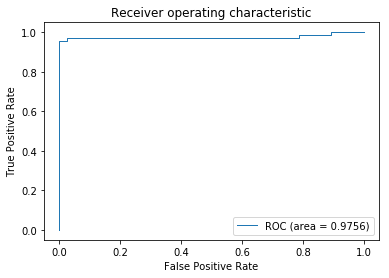

In [15]:
# evaluate and plot roc curve 1
probas = clf1.predict_proba(X_valid)
fpr, tpr, thresholds = roc_curve(y_valid, probas[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.4f)' % roc_auc)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

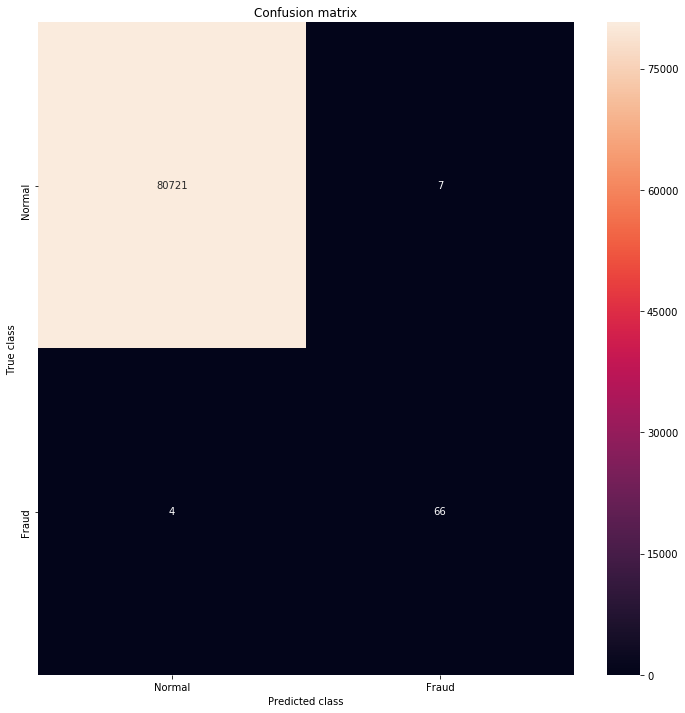

In [16]:
LABELS = ["Normal", "Fraud"]

conf_matrix = confusion_matrix(y_valid, probas[:,1].round())

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [17]:
model = ExtraTreesClassifier()
model.fit(X_train,y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [18]:
print(model.feature_importances_)

[0.01839928 0.01744191 0.01941823 0.01667318 0.04507758 0.01084642
 0.01202365 0.01480927 0.01937529 0.02284619 0.02876407 0.00924566
 0.01390572 0.01521007 0.02216629 0.05107313 0.05104336 0.6116807 ]


In [19]:
clf2 = DecisionTreeClassifier(max_depth=5)

In [20]:
clf2.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

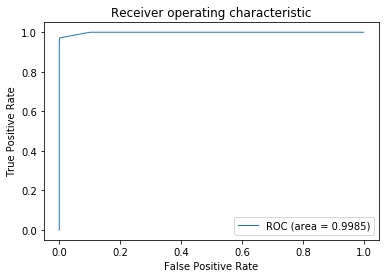

In [21]:
# evaluate and plot roc curve 2
probas = clf2.predict_proba(X_valid)
fpr, tpr, thresholds = roc_curve(y_valid, probas[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.4f)' % roc_auc)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

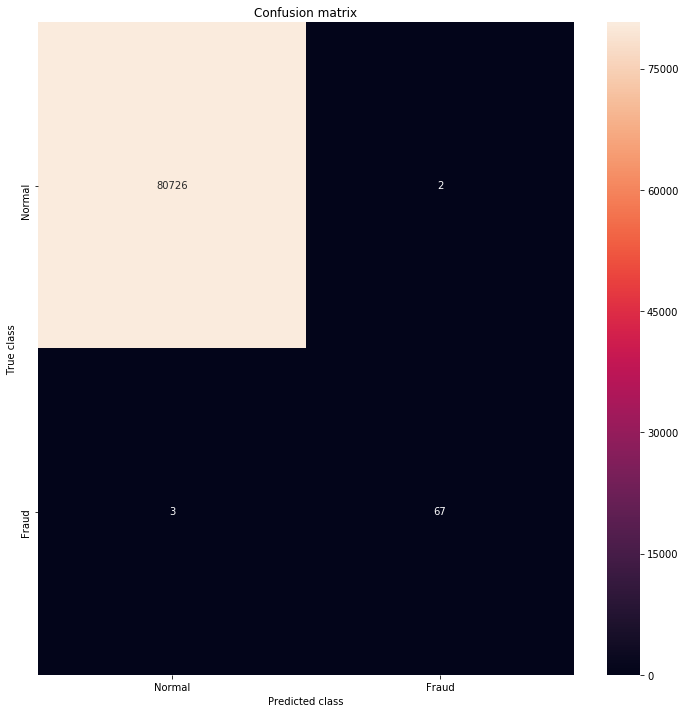

In [22]:
LABELS = ["Normal", "Fraud"]

conf_matrix = confusion_matrix(y_valid, probas[:,1].round())

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [22]:
#Pickle dump of the final dataframe
# pickle_out = open('vars.pickle','wb')
# pickle.dump([X_train,X_valid,y_train,y_valid],pickle_out)
# pickle_out.close()

In [22]:
X_cluster1 = X_valid[:]

In [23]:
print(X_cluster1)

        speciality  nb_diff_prescriptions  sum_prescr  sum_days  sum_cost  \
114624           0               2.572935    2.188240  2.439145  1.092195   
594836           1              -0.655259   -0.437856 -0.462805 -0.410456   
770913           2              -0.098674   -0.246666 -0.174824 -0.242912   
368388           1              -0.655259   -0.442777 -0.463523 -0.410677   
407574           3               0.476464    0.406838  0.637687  0.246681   
157234           4              -0.543942   -0.385957 -0.446917 -0.401542   
696116           5              -0.488283   -0.417275 -0.434671 -0.371381   
414843           6              -0.636706   -0.440540 -0.462741 -0.410368   
218396           0              -0.432625   -0.404003 -0.426881 -0.400849   
567052           1              -0.655259   -0.435917 -0.463294 -0.410516   
239714           6               0.402253    0.035495  0.022675 -0.174049   
756446           5               2.647146    1.498049  1.378253  0.975724   

In [24]:
X_cluster1 = X_cluster1['mahalanobis']

In [25]:
print(X_cluster1)

114624    0.413967
594836   -0.729422
770913   -0.148463
368388   -0.729422
407574   -0.112702
157234    0.890381
696116   -0.255622
414843   -0.257836
218396   -0.385830
567052   -0.729422
239714   -0.280719
756446    0.510611
457495    0.913130
507847   -0.444237
662856    0.657777
298335   -0.329728
369397   -0.358029
39764    -0.217871
206333   -0.181602
569637    0.343777
680909   -0.239024
670374   -0.729422
791837   -0.192918
438866    5.552606
465466   -0.283572
128000   -0.144804
580610   -0.332979
598224    0.862699
131034   -0.729422
114363    0.217273
            ...   
284321   -0.235637
434101   -0.494886
387741    0.199747
621181   -0.120053
519685    0.060618
443804   -0.329670
97151     0.264361
105631   -0.141893
61159     0.222772
617649    0.326492
459001    0.595525
109246   -0.194576
723674    1.504866
70703     0.978301
253368   -0.276694
797536    0.458550
76098     3.586876
654668    0.500854
400546   -0.439555
77714     0.359827
201577   -0.248746
748888   -0.

In [26]:
from sklearn.cluster import KMeans

In [27]:
clustering = KMeans(n_clusters=10, random_state=0)

In [28]:
clustering.fit(X_cluster1.values.reshape(-1,1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [29]:
labels=clustering.labels_

In [30]:
print(labels)

[4 9 0 ... 0 0 5]


In [31]:
unique, counts = numpy.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

{0: 42568, 1: 2902, 2: 316, 3: 25, 4: 7471, 5: 17495, 6: 173, 7: 1048, 8: 2, 9: 8798}


In [32]:
test = []
for label in labels:
    if str(label) in "68":
        test.append(1)
    else:
        test.append(0)

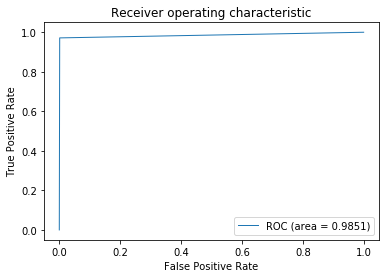

In [33]:
fpr, tpr, thresholds = roc_curve(y_valid, test)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.4f)' % roc_auc)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

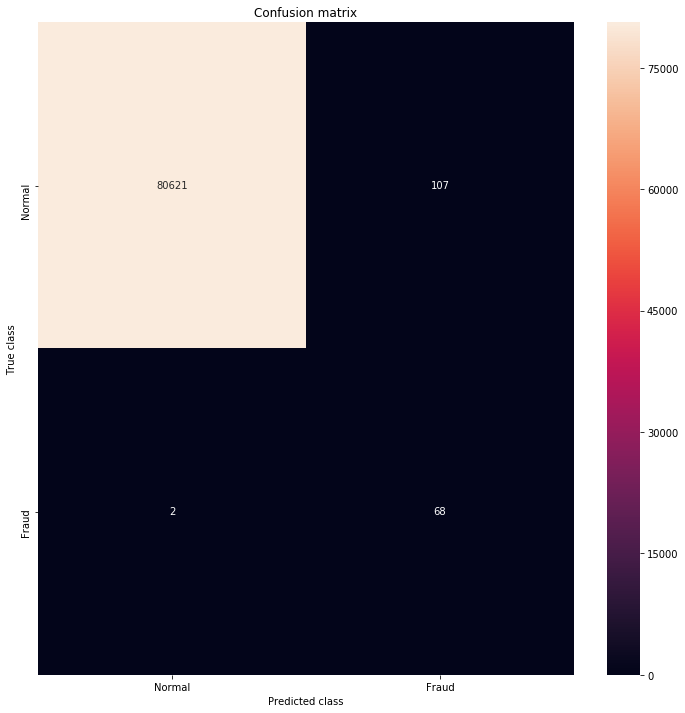

In [34]:
LABELS = ["Normal", "Fraud"]

conf_matrix = confusion_matrix(y_valid, test)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [35]:
X_valid.shape

(80798, 18)